In [1]:
import glob
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import random

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer



from sklearn.metrics import confusion_matrix
import itertools
from sklearn.externals import joblib


from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [2]:
def read_in_dataframes():
    f_list = glob.glob('*_data_df.p')
    df_list = []
    for fname in f_list:
        if 'jupyter' not in fname:
            #if 'guard' in fname:
            df_list.append(pickle.load(open( fname, 'rb' )))
            #print(len(list(df_list[-1])))
    #print(df_list[5])
    print(list(df_list[0]))
    return df_list

def concat_dfs(df_list):
    return pd.concat(df_list)


In [3]:
def get_pub_names(df_list):
    pub_names = [i.loc[0,'label'] for i in df_list]
    return pub_names

def encode_pub_names(full_feature_df, pub_names):
    le = preprocessing.LabelEncoder()
    le.fit(pub_names)
    print('pub', list(le.classes_))
    label_array = full_feature_df['label'].values
    Y = le.transform(label_array)
    return Y, list(le.classes_)


def get_feature_array(full_feature_df, feat_list):
    return full_feature_df[feat_list].values


In [4]:
def modify_full_dataframe(full_feature_df):
    #full_feature_df = full_feature_df.loc[full_feature_df['sent_count'] > 10]

    #full_feature_df['sent_len_mean_over_std'] = full_feature_df['sent_len']/full_feature_df['sent_len_std']
    #full_feature_df = full_feature_df.loc[(full_feature_df['sent_len_std'] > 0) & (full_feature_df['sent_len'] > 0)]

    #full_feature_df['flesch_dff'] = full_feature_df['flesch_five'] - full_feature_df['flesch']
    #full_feature_df['fq1'] = full_feature_df['flesch_sec'].str[0]
    #full_feature_df['fq2'] = full_feature_df['flesch_sec'].str[1]
    #full_feature_df['fq3'] = full_feature_df['flesch_sec'].str[2]
    #full_feature_df['fq4'] = full_feature_df['flesch_sec'].str[3]
    #full_feature_df['flesch_slope'] = full_feature_df['flesch_sec'].apply(lambda row: sum([row[ci+1] - row[ci] for ci in range(3)])/4)
    #print(full_feature_df['flesch_slope'])
    min_word_count = 100
    full_feature_df = full_feature_df.loc[(full_feature_df['word_count'] > min_word_count)]
    full_featuer_df = full_feature_df.loc[(full_feature_df['flesch'] > 0)]
    return full_feature_df

In [5]:
def save_mean_vals(df_list, pub_names):
    mean_values = []
    for ci,label_id in enumerate(pub_names):
        mean_values.append(df_list[ci][feat_list[:-1]].mean().tolist())
    pickle.dump(mean_values, open('mean_features.p', 'wb'))


In [21]:
def plot_feature_histograms(df_list, feat_list, pub_names):
    legend = []
    plt.figure(figsize=(12,8))
    plt.xlabel('Sentence length', fontsize = 24)
    colors = ['#b80c09', '#fcba04', '#01baef']
    count = 0
    for ci,label_id in enumerate(pub_names):
        if label_id in ['nyt','breit','wapo']:
            legend.append(label_id)
            df_list[ci].loc[(df_list[ci]['word_count'] < 6000) & (df_list[ci]['sent_len'] < 70)]['sent_len'].hist(
                bins = [i/10 for i in range(0,500,10)], alpha = 0.6, normed = True, color = colors[count])
            count += 1
    plt.legend(['New York Times', 'Breitbart', 'Washington Post'], fontsize = 24)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)

In [7]:
def feature_correlations(full_feature_df):
    corr = full_feature_df[feat_list].corr()
    
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    plt.figure(figsize=(10,10))
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr,cmap=cmap, center=0,
                square=True, linewidths=.3, cbar_kws={"shrink": .8})

In [14]:
def train_model(model, X_train, y_train, title):

    #for i in range(100,4500, 400):
    #    rand_start = random.randint(0,4500 - i)
    #    rf_clf = rf_clf.fit(X_train[rand_start:rand_start + i], y_train[rand_start:rand_start + i])

    #    print(rf_clf.score(X_test, y_test))
    model = model.fit(X_train, y_train)
    return model
    
    
    
def score_model(y_test, y_pred, pub_names, title):
    
    #print(model.score(X_test, y_test))
    
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=pub_names,
                      title='Confusion matrix: ' + title, normalize = True)

    #plot_auc_roc(model)
    #return y_pred
    
    
def score_model_top_two(y_test, y_pred_prob, pub_names, title):
    
    #print(model.score(X_test, y_test))
    y_pred = []
    for true, row in zip(y_test, y_pred_prob):
        if true in row.argsort()[-2:][::-1]:
            y_pred.append(true)
        else:
            y_pred.append(row.argmax())
                
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=pub_names,
                      title='Confusion matrix: ' + title, normalize = True)

    plot_auc_roc(model)
    #return y_pred
    
    
    
def plot_auc_roc(model):
    # Compute ROC curve and ROC area for each class
    one_v_rest = OneVsRestClassifier(model).fit(X_stats_train, y_train)
    print(one_v_rest.score(X_stats_test, y_test))
    y_pred = one_v_rest.predict(X_test)
    y_score = one_v_rest.fit(X_train, y_train).decision_function(X_stats_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    #print(len(class_names))
    #print(len(y_test))
    #print(len(y_score))
    for i in range(len(pub_names)):
        fpr[i], tpr[i], _ = roc_curve( (y_test == i).astype(int), y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    #fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    #roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    plt.figure()
    lw = 2
    for i in range(9):
        plt.plot(fpr[i], tpr[i], 
                 lw=lw, label='{} (area = {})'.format(str(class_names[i]), str(roc_auc[i])))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    
#New York Times', 'Breitbart', 'Washington Post', 'Guardian']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha = 'right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix

def feature_importances(model, feat_list):
    n_features = len(feat_list)
    importances = model.feature_importances_
    #std = np.std([tree.feature_importances_ for tree in xg_clf.estimators_],
    #             axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(n_features):#.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

        # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(n_features), importances[indices],
           color="r", align='center')#, yerr=std[indices], align="center")
    #plt.bar(range(40), importances[indices[:40]],
    #       color="r", align='center')#, yerr=std[indices], align="center")

    print(indices)
    plt.xticks(range(n_features), [feat_list[i] for i in indices], rotation = 45, ha = 'right')
    plt.xlim([-1, n_features])
    #plt.xticks(range(40), [feature_names[i] for i in indices[:40]], rotation = 45, ha = 'right')
    #plt.xlim([-1, 40])

    plt.show()



In [9]:
def tsne(X, Y):
    #X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
    from sklearn.manifold import TSNE
    X_embedded = TSNE(perplexity = 10, n_components=2).fit_transform(X)
    print(X_embedded.shape)
    
    colorlist = 'rgbcmykrg'
    color = [colorlist[i] for i in Y]
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=color, cmap=plt.cm.Spectral, s = 0.5)

In [11]:
#read in data and concatenate into large dataframe
df_list = read_in_dataframes()
full_feature_df = concat_dfs(df_list)
print(list(full_feature_df))
#trim the dataframe (e.g. to cut out short articles) or add new feature columns
full_feature_df = modify_full_dataframe(full_feature_df)

#set feature list
feat_list = ['sent_len', 'word_len', 'sent_len_std', 'unique_word_frac',                                                                     
                'cps', 'qps', 'exps', 'foreign', 'flesch',                                                                                                     
                'RB_ps', 'RBR_ps', 'RBS_ps', 'WRB_ps', 'VB_ps',                                                                                                
                'VBD_ps', 'VBG_ps', 'VBN_ps', 'VBP_ps', 'VBZ_ps', 'JJ_ps', 'JJS_ps', 'JJR_ps',                                                                 
                'said_ps', 'and_ps', 'but_ps', 'told_ps', 'i_ps', 'pronoun_ps', 'determiner_ps', 
                'preposition_ps', 'word_rarity', 'pos_string']
             
#feat_list = ['sent_len', 'word_len', 'sent_len_std', 'unique_word_frac',                                                                     
#                'cps', 'flesch',                                                                                               
#                'said_ps', 'qps', 'and_ps', 'but_ps', 'told_ps', 'i_ps', 'word_rarity' , 'pos_string'  ]

#encode label ids, and get target publication list
pub_names = get_pub_names(df_list)
print(pub_names)
pub_names_original_order = pub_names
Y, pub_names = encode_pub_names(full_feature_df, pub_names)
X = get_feature_array(full_feature_df, feat_list)
n_samples = len(X)


article_counts = full_feature_df.groupby('label')['label'].count().tolist()

cumulative_bounds = [0]
for ci, i in enumerate(article_counts):
    cumulative_bounds.append(i+cumulative_bounds[ci])
print(cumulative_bounds)


#X_scaled = preprocessing.scale(X)

#test train split
indices = np.arange(n_samples)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, Y, indices, test_size=0.2)


['label', 'word_count', 'sent_len', 'word_len', 'sent_len_std', 'unique_word_frac', 'cps', 'qps', 'exps', 'adverbs', 'verbs', 'adjectives', 'foreign', 'flesch', 'said_ps', 'and_ps', 'but_ps', 'flesch_five', 'flesch_sec', 'total_adv', 'total_verb', 'total_adj', 'sent_count', 'adv_ps', 'verb_ps', 'adj_ps', 'RB_ps', 'RBR_ps', 'RBS_ps', 'WRB_ps', 'VB_ps', 'VBD_ps', 'VBG_ps', 'VBN_ps', 'VBP_ps', 'VBZ_ps', 'JJ_ps', 'JJS_ps', 'JJR_ps', 'told_ps', 'i_ps', 'ngram_DT NN', 'ngram_NN NN', 'ngram_NN IN', 'ngram_IN DT', 'ngram_NN PP', 'ngram_JJ NN', 'ngram_IN NN', 'ngram_NN VB', 'ngram_PRP VB', 'ngram_VB IN', 'ngram_DT JJ', 'ngram_PP NN', 'ngram_PP PP', 'ngram_VB DT', 'ngram_CD NN', 'ngram_PP JJ', 'ngram_PP DT', 'ngram_PP VB', 'ngram_VB VB', 'ngram_PRP$ NN', 'ngram_TO VB', 'ngram_CD PP', 'ngram_NN CC', 'ngram_VB NN', 'ngram_PP PRP', 'ngram_VB JJ', 'ngram_MD VB', 'ngram_IN JJ', 'ngram_VB PP', 'ngram_PP IN', 'ngram_$ CD', 'ngram_PP CC', 'ngram_RB VB', 'ngram_VB RB', 'ngram_PP CD', 'ngram_JJ JJ', 'ngra

/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


['JJR_ps', 'JJS_ps', 'JJ_ps', 'RBR_ps', 'RBS_ps', 'RB_ps', 'VBD_ps', 'VBG_ps', 'VBN_ps', 'VBP_ps', 'VBZ_ps', 'VB_ps', 'WRB_ps', 'adj_ps', 'adjectives', 'adv_ps', 'adverbs', 'and_ps', 'article_id', 'but_ps', 'cps', 'determiner_ps', 'exps', 'flesch', 'flesch_five', 'flesch_sec', 'foreign', 'i_ps', 'label', 'ngram_# JJ', 'ngram_# NN', 'ngram_# VB', 'ngram_$ CD', 'ngram_CC DT', 'ngram_CC IN', 'ngram_CC JJ', 'ngram_CC NN', 'ngram_CC PP', 'ngram_CC VB', 'ngram_CC WP', 'ngram_CD CD', 'ngram_CD DT', 'ngram_CD IN', 'ngram_CD JJ', 'ngram_CD NN', 'ngram_CD PP', 'ngram_DT CD', 'ngram_DT JJ', 'ngram_DT NN', 'ngram_DT PP', 'ngram_DT PRP', 'ngram_DT VB', 'ngram_EX VB', 'ngram_FW FW', 'ngram_FW JJ', 'ngram_FW NN', 'ngram_IN CD', 'ngram_IN DT', 'ngram_IN FW', 'ngram_IN IN', 'ngram_IN JJ', 'ngram_IN NN', 'ngram_IN PP', 'ngram_IN PRP', 'ngram_IN PRP$', 'ngram_IN VB', 'ngram_IN WP', 'ngram_JJ #', 'ngram_JJ CC', 'ngram_JJ CD', 'ngram_JJ DT', 'ngram_JJ FW', 'ngram_JJ IN', 'ngram_JJ JJ', 'ngram_JJ NN', 'ngra

In [ ]:
#tsne(X_test[:,:-1], y_test)
#print(full_feature_df['article_id'])
df_1 = pd.read_csv('articles1.csv')
df_2 = pd.read_csv('articles2.csv')
df_3 = pd.read_csv('articles3.csv')
#print(df_1.head(1))
print(df_1.shape)

#print(df_1.publication.unique())
#print(df_2.publication.unique())
#print(df_3.publication.unique())
#merge dataframes
total_df = pd.concat([df_1, df_2, df_3])
df_1 = 0
df_2 = 0
df_3 = 0

In [74]:
#print(list(full_feature_df['article_id']))
print(total_df.head())
print(len(total_df))
print(len(full_feature_df))

   Unnamed: 0     id                                              title  \
0           0  17283  House Republicans Fret About Winning Their Hea...   
1           1  17284  Rift Between Officers and Residents as Killing...   
2           2  17285  Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...   
3           3  17286  Among Deaths in 2016, a Heavy Toll in Pop Musi...   
4           4  17287  Kim Jong-un Says North Korea Is Preparing to T...   

      publication                         author        date    year  month  \
0  New York Times                     Carl Hulse  2016-12-31  2016.0   12.0   
1  New York Times  Benjamin Mueller and Al Baker  2017-06-19  2017.0    6.0   
2  New York Times                   Margalit Fox  2017-01-06  2017.0    1.0   
3  New York Times               William McDonald  2017-04-10  2017.0    4.0   
4  New York Times                  Choe Sang-Hun  2017-01-02  2017.0    1.0   

   url                                            content  
0  NaN  WASHIN

In [79]:
join_df = full_feature_df.set_index('article_id').join(total_df.set_index('id'), how = 'inner')

In [90]:
print(len(join_df))
#print(join_df.head())
print(join_df.loc[join_df['publication'] == 'Fox News']['author'].nunique())

43302
213


/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


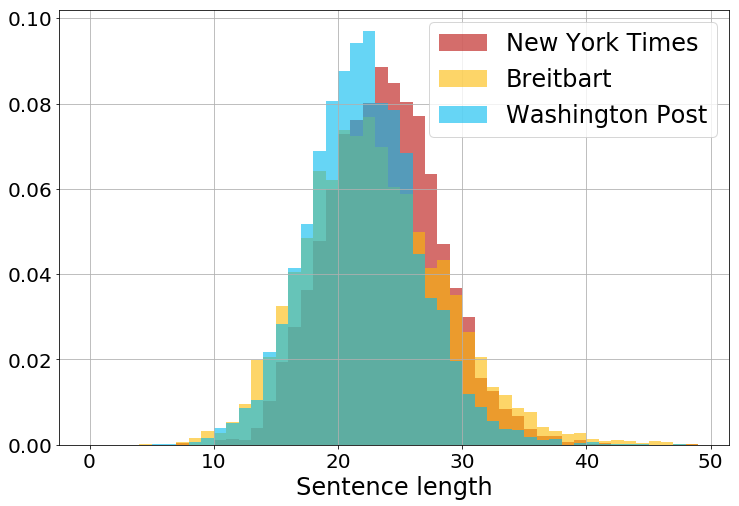

In [22]:
plot_feature_histograms(df_list, feat_list, pub_names_original_order)
#save_mean_vals(df_list, pub_names)

In [19]:
#model = RandomForestClassifier(n_estimators=50)
#model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.25,max_depth=5)
#
model = XGBClassifier(max_depth = 6, n_estimators = 100, feature_names = feat_list[:-1])
#from sklearn.linear_model import LogisticRegression
#model = LogisticRegression(solver='saga',
#                                multi_class='multinomial',
#                                C=1,
#                                penalty='l2',
#                                random_state=42,
#                                )
#from sklearn.naive_bayes import MultinomialNB

#model = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)


X_stats_train = X_train[:, :-1]
X_stats_test = X_test[:,:-1]


stats_pipeline = Pipeline([
    ('clf', model),
])

eval_set = [(X_stats_test, y_test)]

model.fit(X_stats_train, y_train)#, eval_set=eval_set, eval_metric='error', verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1,
       feature_names=['sent_len', 'word_len', 'sent_len_std', 'unique_word_frac', 'cps', 'qps', 'exps', 'foreign', 'flesch', 'RB_ps', 'RBR_ps', 'RBS_ps', 'WRB_ps', 'VB_ps', 'VBD_ps', 'VBG_ps', 'VBN_ps', 'VBP_ps', 'VBZ_ps', 'JJ_ps', 'JJS_ps', 'JJR_ps', 'said_ps', 'and_ps', 'but_ps', 'told_ps', 'i_ps', 'pronoun_ps', 'determiner_ps', 'preposition_ps', 'word_rarity'],
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [45]:
proba_test = model.predict_proba(X_stats_test)
proba_train = model.predict_proba(X_stats_train)

In [48]:
#print(len(proba_test), len(proba_train))

8661 34641


In [28]:
from sklearn.metrics import roc_curve
y_stats_pred = stats_pipeline.predict_proba(X_stats_test)
roc_curve(y_test,y_stats_pred)

ValueError: multiclass format is not supported

[2.13e+01 4.89e+00 6.48e+01 4.16e-01 1.20e+00 1.45e-02 0.00e+00 0.00e+00
 4.98e+01 8.26e-01 2.90e-02 1.45e-02 7.25e-02 1.12e+00 2.61e-01 4.78e-01
 6.38e-01 6.81e-01 5.80e-01 1.75e+00 2.90e-02 2.90e-02 0.00e+00 6.23e-01
 1.01e-01 0.00e+00 1.45e-02 5.80e-01 2.19e+00 2.65e+00 3.67e+03]
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1,
       feature_names=['sent_len', 'word_len', 'sent_len_std', 'unique_word_frac', 'cps', 'qps', 'exps', 'foreign', 'flesch', 'RB_ps', 'RBR_ps', 'RBS_ps', 'WRB_ps', 'VB_ps', 'VBD_ps', 'VBG_ps', 'VBN_ps', 'VBP_ps', 'VBZ_ps', 'JJ_ps', 'JJS_ps', 'JJR_ps', 'said_ps', 'and_ps', 'but_ps', 'told_ps', 'i_ps', 'pronoun_ps', 'determiner_ps', 'preposition_ps', 'word_rarity'],
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,

/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

          0       0.44      0.47      0.46       919
          1       0.51      0.51      0.51       986
          2       0.45      0.51      0.48       858
          3       0.51      0.49      0.50       899
          4       0.30      0.36      0.33       778
          5       0.63      0.47      0.54      1332
          6       0.68      0.62      0.65      1074
          7       0.57      0.54      0.56      1024
          8       0.31      0.40      0.35       791

avg / total       0.51      0.49      0.50      8661

Normalized confusion matrix
[[0.44 0.04 0.05 0.04 0.07 0.15 0.05 0.12 0.05]
 [0.05 0.51 0.08 0.11 0.08 0.08 0.02 0.04 0.04]
 [0.05 0.11 0.45 0.1  0.08 0.02 0.07 0.04 0.08]
 [0.03 0.1  0.1  0.51 0.08 0.05 0.05 0.02 0.07]
 [0.07 0.07 0.09 0.1  0.3  0.1  0.1  0.06 0.09]
 [0.1  0.05 0.01 0.01 0.05 0.63 0.01 0.1  0.05]
 [0.06 0.01 0.03 0.02 0.06 0.02 0.68 0.03 0.08]
 [0.07 0.06 0.02 0.01 0.04 0.16 0.01 0.57 0.05]
 [

/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Normalized confusion matrix
[[0.64 0.03 0.03 0.02 0.04 0.11 0.03 0.06 0.04]
 [0.02 0.74 0.03 0.05 0.03 0.05 0.01 0.02 0.03]
 [0.04 0.05 0.66 0.07 0.05 0.02 0.04 0.02 0.05]
 [0.02 0.07 0.04 0.68 0.05 0.04 0.04 0.01 0.05]
 [0.05 0.04 0.05 0.07 0.57 0.07 0.05 0.04 0.06]
 [0.06 0.02 0.01 0.01 0.02 0.8  0.   0.07 0.02]
 [0.04 0.01 0.01 0.01 0.03 0.02 0.82 0.02 0.03]
 [0.05 0.03 0.01 0.01 0.03 0.08 0.01 0.75 0.03]
 [0.05 0.04 0.04 0.05 0.05 0.13 0.07 0.07 0.5 ]]


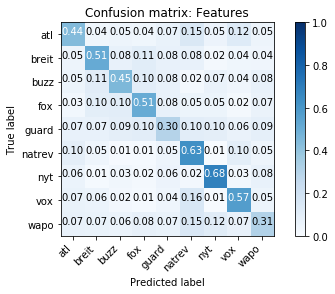

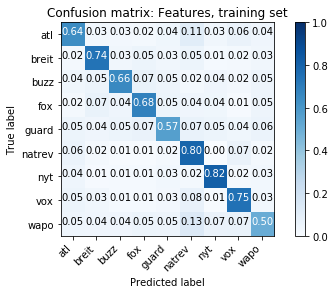

In [20]:
#train_model(model, X_stats_train, y_train)
print(X_stats_test[0].astype(float))
#import xgboost as xg
print(stats_pipeline.steps[0][1])
y_stats_pred = stats_pipeline.predict(X_stats_test)
print(classification_report(y_stats_pred, y_test))
score_model(y_test, y_stats_pred, pub_names, 'Features')
y_stats_pred_train = stats_pipeline.predict(X_stats_train)
score_model(y_train, y_stats_pred_train, pub_names, 'Features, training set')

In [28]:
feat_label_df = pd.DataFrame({feat_list[i]: X_stats_test[:,i] for i in range(len(feat_list)-1)})
feat_label_df['true'] = y_test
feat_label_df['pred'] = y_stats_pred

false_df = feat_label_df.loc[feat_label_df['true'] != feat_label_df['pred']]
true_df = feat_label_df.loc[feat_label_df['true'] == feat_label_df['pred']]

#plt.hist2d(false_df['true'].tolist(), false_df['pred'].tolist(),  bins = 9)
#plt.show()
#plt.hist2d(true_df['true'].tolist(), true_df['pred'].tolist(),  bins = 9)
#plt.show()

0.14919141961286184
0.2675301856834456
1.785819720496196e-06


/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


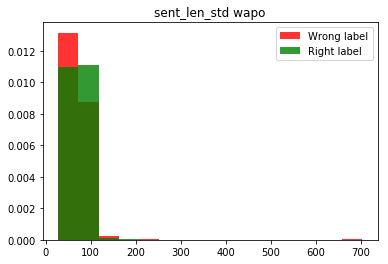

3.8049882050267557e-17


/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


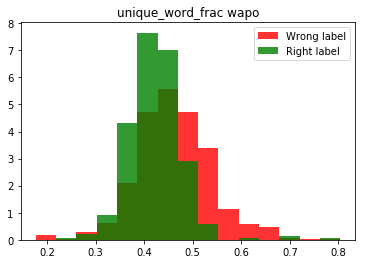

2.8489292603627503e-05


/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


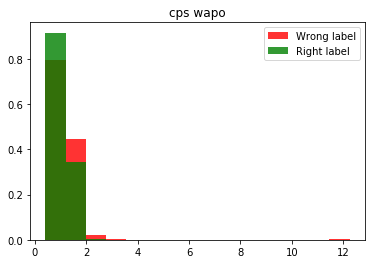

0.1744588023592122
0.14974489640767713
0.9406540613952491
0.06488112028013791
4.881001370449087e-12


KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt
/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


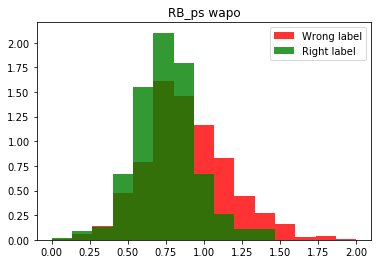

0.002849228801472475


/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


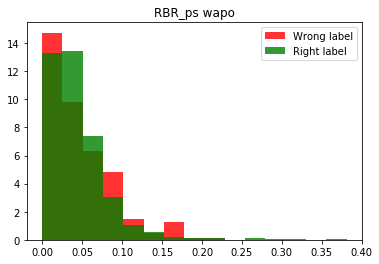

0.006269434293703141


/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


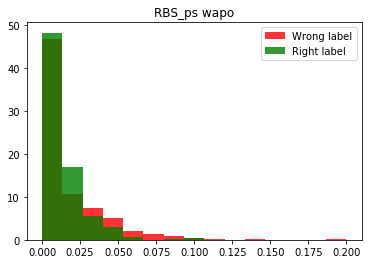

0.0814795161078391
0.17270173355588767
5.868221821946011e-08


/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


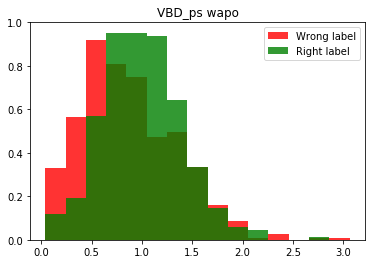

0.24671889229093857
0.5183708150641865
0.002583556096669731


/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


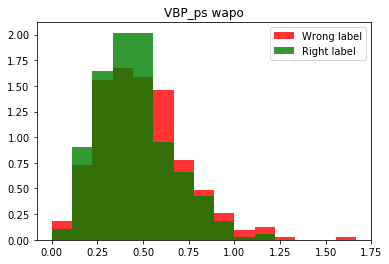

0.0007161969925689099


/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


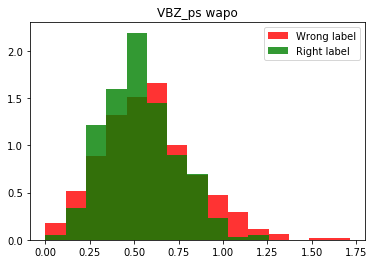

0.33315814467741484
0.0018409439677370082


/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


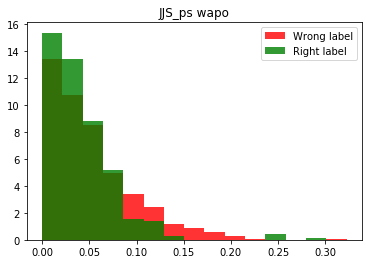

0.06368389536877464
3.499501073381115e-21


/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


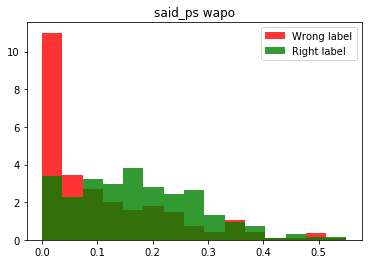

0.01336365353431684
0.06538560684090847
0.16052417376869071
0.27021898062517946
0.010064364474754678
0.3284017635776303
0.004875594704113847


/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


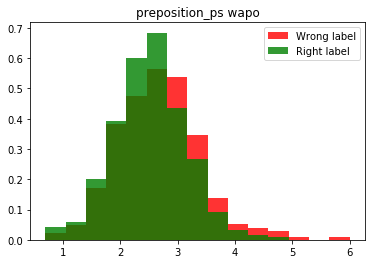

0.2011344828514027


In [31]:
from scipy import stats
#x = np.linspace(-15, 15, 9)
#print(x)
#stats.ks_2samp(x, 'norm')


#for i in range(9):
for feat in feat_list[:-1]:
    #data for the correct predictions for publication i
    true_data = true_df.loc[true_df['true'] == pub_names.index('wapo')][feat].tolist()
    #data for false predictions for publication i
    false_data = false_df.loc[false_df['true'] == pub_names.index('wapo')][feat].tolist()
    D, p_val = stats.ks_2samp(true_data, false_data)
    print(p_val)
    if p_val < 0.01:
        plt.title(feat + ' '+ pub_names[pub_names.index('wapo')])
        data = plt.hist(false_data, bins = 15, normed = True, alpha = 0.8, color = 'r')
        plt.hist(true_data, bins = data[1], normed = True, alpha = 0.8, color = 'g')
        plt.legend(['Wrong label', 'Right label'])
        plt.show()
    
#plt.show()
#print(feat_label_df)
#print(y_stats_pred)
#target = 3
#for shap in y_stats_pred:
#    print(shap)
#    for pub in shap:
#        print(pub)
#        plt.bar(range(len(pub)), np.asarray(pub))
#        #plt.bar(range(len(pub)), shap[target])
#        plt.show()

In [182]:
import model_t
import importlib
importlib.reload(model_t)

<module 'model_t' from '/home/joseph/insight/project/news/model_t.py'>

0
------------- 0
[20.571428571428573, 4.380787037037037, 79.43866628210895, 0.4398148148148148, 1.0714285714285714, 0.11904761904761904, 0.023809523809523808, 0, 71.24, 1.0238095238095237, 0.023809523809523808, 0.0, 0.11904761904761904, 0.8333333333333334, 1.2142857142857142, 0.3333333333333333, 0.5714285714285714, 0.23809523809523808, 0.6428571428571429, 1.5, 0.023809523809523808, 0.0, 0.11904761904761904, 0.19047619047619047, 0.023809523809523808, 0.0, 0.0, 1.5714285714285714, 2.4047619047619047, 2.4047619047619047, 19029.89351851852]
31 31 31


/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


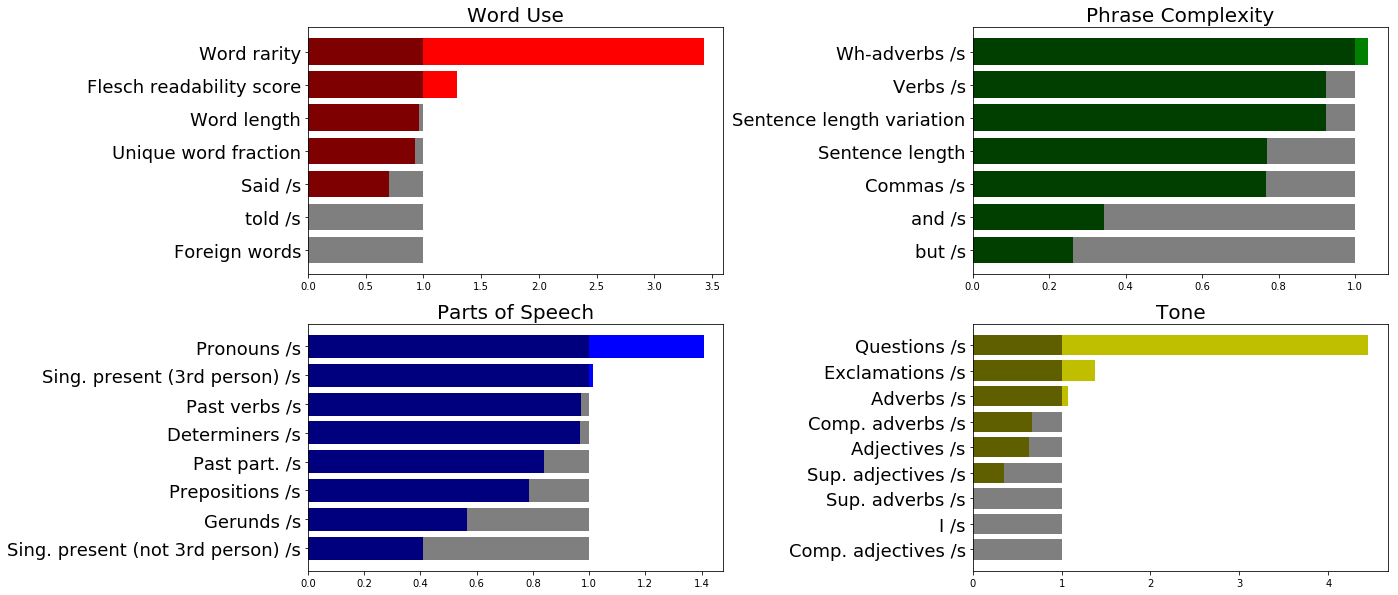

In [183]:
with open('melania_jacket.txt') as f:
    text = f.readlines()
    text = [i.strip() for i in text]
text = ' '.join(text)
#print(text)
feat_array = model_t.generate_features(text)
print(feat_array)
print(len(feat_array), len(feat_list[:-1]), len(X_stats_test[0]))
#model_t.pre_process_text(text)
stats_pipeline.predict(feat_array)

id_to_pub = {0: 'The Atlantic',1:'Breitbart', 2:'Buzzfeed News', 3:'Fox News', 4:'The Guardian', 5:'National Review', 6:'The New York Times',
            7:'Vox', 8:'The Washington Post'}

pub_to_id = {'The Atlantic': 0,'Breitbart': 1, 'Buzzfeed News': 2, 'Fox News': 3, 'The Guardian': 4, 'National Review': 5, 'The New York Times'\
: 6, 'Vox': 7, 'The Washington Post': 8}

target_pub = 'The New York Times'

text_features = feat_array

mean_features = pickle.load(open('./mean_features.p', 'rb'))

mean_features_comp = model_t.compare_to_mean(text_features, mean_features)


categories = {'Word Use': ['word_len', 'unique_word_frac', 'flesch', 'word_rarity', 'foreign','said_ps', 'told_ps'], 
              'Phrase Complexity': ['sent_len', 'sent_len_std' , 'cps', 'WRB_ps','and_ps', 'but_ps', 'VB_ps'], 
              'Parts of Speech': ['VBD_ps', 'VBG_ps', 'VBN_ps', 'VBP_ps', 'VBZ_ps',                                                                
                 'pronoun_ps', 'determiner_ps', 
                'preposition_ps'], 
              'Tone': ['qps', 'exps', 'RB_ps', 'RBS_ps', 'RBR_ps', 'JJ_ps', 'JJS_ps', 'JJR_ps' ,'i_ps']}


model_t.plot_target_comp(id_to_pub, pub_to_id, text_features, mean_features, target_pub, categories)


Normalized confusion matrix
[[0.44 0.04 0.05 0.04 0.06 0.17 0.05 0.1  0.05]
 [0.04 0.51 0.08 0.12 0.06 0.1  0.02 0.03 0.04]
 [0.06 0.12 0.47 0.11 0.07 0.02 0.05 0.04 0.06]
 [0.03 0.14 0.08 0.5  0.07 0.04 0.04 0.02 0.08]
 [0.08 0.07 0.12 0.09 0.3  0.1  0.08 0.06 0.09]
 [0.1  0.05 0.01 0.01 0.04 0.62 0.01 0.1  0.06]
 [0.07 0.02 0.03 0.03 0.07 0.02 0.67 0.03 0.07]
 [0.09 0.07 0.03 0.02 0.04 0.13 0.01 0.55 0.05]
 [0.06 0.07 0.06 0.08 0.09 0.15 0.09 0.08 0.31]]


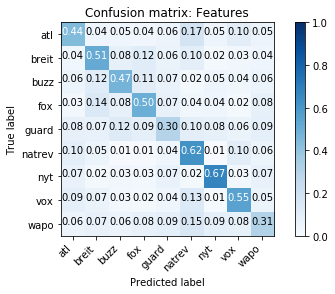

{'f22': 4897, 'f4': 6223, 'f26': 3589, 'f5': 2802, 'f18': 4511, 'f0': 3551, 'f21': 3431, 'f12': 3725, 'f2': 6209, 'f24': 4113, 'f19': 4066, 'f1': 5988, 'f8': 6386, 'f7': 1152, 'f9': 5099, 'f3': 7474, 'f30': 5840, 'f14': 4694, 'f29': 3981, 'f6': 1469, 'f27': 4996, 'f28': 4440, 'f10': 3180, 'f11': 2087, 'f13': 4750, 'f17': 4560, 'f16': 4790, 'f20': 3373, 'f23': 4530, 'f25': 2762, 'f15': 4409}
[('sent_len', 3551), ('word_len', 5988), ('sent_len_std', 6209), ('unique_word_frac', 7474), ('cps', 6223), ('qps', 2802), ('exps', 1469), ('foreign', 1152), ('flesch', 6386), ('RB_ps', 5099), ('RBR_ps', 3180), ('RBS_ps', 2087), ('WRB_ps', 3725), ('VB_ps', 4750), ('VBD_ps', 4694), ('VBG_ps', 4409), ('VBN_ps', 4790), ('VBP_ps', 4560), ('VBZ_ps', 4511), ('JJ_ps', 4066), ('JJS_ps', 3373), ('JJR_ps', 3431), ('said_ps', 4897), ('and_ps', 4530), ('but_ps', 4113), ('told_ps', 2762), ('i_ps', 3589), ('pronoun_ps', 4996), ('determiner_ps', 4440), ('preposition_ps', 3981), ('word_rarity', 5840)]


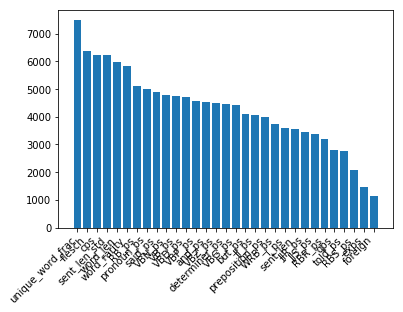

{'f22': 13.063720954627609, 'f4': 5.457392287761646, 'f26': 3.7745389801924953, 'f5': 4.357572317409587, 'f18': 2.7168823609157284, 'f0': 2.9699800492935946, 'f21': 3.703834657681435, 'f12': 2.600332075376817, 'f2': 4.07358688987044, 'f24': 4.9945040136368775, 'f19': 2.6067506922032724, 'f1': 3.633626728097279, 'f8': 4.825202942194891, 'f7': 10.039468269950845, 'f9': 3.8347025018839807, 'f3': 6.878886705158918, 'f30': 3.1604415914240453, 'f14': 2.924277748831012, 'f29': 3.0272459862380976, 'f6': 2.861233747711453, 'f27': 3.0902570110052126, 'f28': 3.0538287093549936, 'f10': 3.753579387550092, 'f11': 2.5944787444612114, 'f13': 2.6434745481701873, 'f17': 3.0286200809033477, 'f16': 3.492146002961147, 'f20': 3.4314178499708916, 'f23': 2.530988430426629, 'f25': 7.6703942918564145, 'f15': 2.6749665796311297}
[('sent_len', 2.9699800492935946), ('word_len', 3.633626728097279), ('sent_len_std', 4.07358688987044), ('unique_word_frac', 6.878886705158918), ('cps', 5.457392287761646), ('qps', 4.357

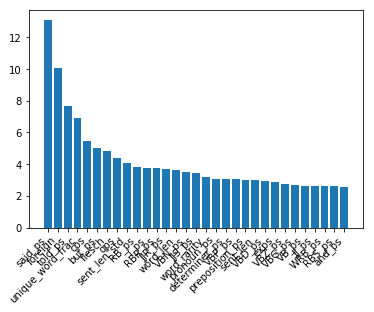

22


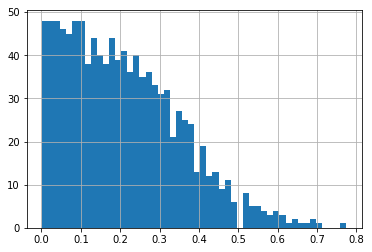

In [59]:
score_model(y_test, y_stats_pred, pub_names, 'Features')
plt.show()
#feature_importances(stats_pipeline.steps[0][1], feat_list[:-1])
#stats_pipeline.get_fscore()
#import xgboost
#model.save_model('save_model')
#booster = xgboost.Booster(model)
import xgboost
xgb = stats_pipeline.steps[0][1]
weight_importance = xgb.get_booster().get_score( importance_type='weight')
print(weight_importance)
weight_importance = {int(k[1:]):v for k,v in weight_importance.items()}
weight_importance_list = [(feat_list[i], weight_importance[i]) for i in range(len(weight_importance))]
sort_weight = sorted(weight_importance_list, key=lambda tup: tup[1])[::-1]

print(weight_importance_list)
plt.bar(range(len(weight_importance_list)), [i[1] for i in sort_weight])
plt.xticks(range(len(sort_weight)), [i[0] for i in sort_weight], rotation=45, ha = 'right')#print(weight_importance)
#xgb.get_booster().get_split_value_histogram('f30')['SplitValue'].hist(bins = 50)
plt.show()
gain_importance = xgb.get_booster().get_score( importance_type='gain')
print(gain_importance)
gain_importance = {int(k[1:]):v for k,v in gain_importance.items()}
gain_importance_list = [(feat_list[i], gain_importance[i]) for i in range(len(gain_importance))]
sort_gain = sorted(gain_importance_list, key=lambda tup: tup[1])[::-1]


print(gain_importance_list)
plt.bar(range(len(gain_importance_list)), [i[1] for i in sort_gain])
plt.xticks(range(len(feat_list[:-1])), [i[0] for i in sort_gain], rotation=45, ha = 'right')
plt.show()

xgb.get_booster().get_split_value_histogram('f'+str(feat_list.index('said_ps')))['SplitValue'].hist(bins = 50)
print(feat_list.index('said_ps'))

In [52]:
joblib.dump(stats_pipeline, 'stats_xgb_6_27.pkl') 

['stats_xgb_6_27.pkl']

In [ ]:
y_stats_pred_prob = stats_pipeline.predict_proba(X_stats_test)
print(y_stats_pred_prob)

In [ ]:
#top_one = y_stats_pred_prob[np.where( np.argmax(y_stats_pred_prob) == 2 )]#, interpolation = None)
#top_one = [i for i in y_stats_pred_prob if np.argmax(i) == 0]
#print(top_one)
#plt.imshow(top_one[:30], interpolation = None)

corr = pd.DataFrame({pub_names[i]: (y_stats_pred_prob[:,i]) for i in range(len(pub_names))}).corr()
    
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(10,10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,cmap=cmap, center=0, mask = mask, vmax=.3,
            square=True, linewidths=.3, cbar_kws={"shrink": .5})


#for i in range(9):
#    for j in range(i+1,9):
#        plt.title(str(i) + ' ' + str(j))
#        plt.scatter((y_stats_pred_prob[:,i]), (y_stats_pred_prob[:,j]))
#        plt.show()
#score_model(y_test, y_stats_pred)
score_model_top_two(y_test, y_stats_pred_prob, pub_names, 'Features')


In [ ]:
print(classification_report(y_test, y_stats_pred))

score_model(y_test, y_stats_pred, pub_names, 'Features')

feature_importances(stats_pipeline.steps[0][1], feat_list[:-1])

#tsne(X,Y)

In [ ]:
#save model
joblib.dump(stats_pipeline, 'stats_gbt.pkl') 

In [ ]:
#from sklearn.naive_bayes import MultinomialNB
#clf = MultinomialNB().fit(X_train_tfidf, y_pos_train)
#X_pos = full_feature['pos_string'].values

#X_pos_train, X_pos_test, y_pos_train, y_pos_test, idx_pos_train, idx_pos_test = train_test_split(
#    full_feature_df['pos_string'].values, Y, indices, test_size=0.2)


#print(len(full_feature_df['pos_string']))

X_pos_train = X_train[:, -1]
X_pos_test = X_test[:,-1]
print(X_pos_train[0])

In [ ]:
#from sklearn.feature_extraction.text import CountVectorizer
#count_vect = CountVectorizer()
#X_train_counts = count_vect.fit_transform(X_pos_test)
#print(X_train_counts.shape)

#vectorizer = TfidfVectorizer(min_df = 10, ngram_range=(4,4))
#X_train_tfidf = vectorizer.fit_transform(X_pos_train)



#tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
#X_train_tf = tf_transformer.transform(X_train_counts)
#X_train_tf.shape

#print(X_train_tfidf.shape)


#X_new_counts = count_vect.transform(X_pos_test)
#X_new_tfidf = vectorizer.transform(X_pos_test)

In [ ]:
#clf = RandomForestClassifier(n_estimators=50).fit(X_train_tfidf, y_train)


#y_pos_pred = clf.predict(X_new_tfidf)

In [ ]:
#score_model(X_new_tfidf, y_test, y_pos_pred, pub_names, 'Features')

In [23]:
pos_string_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(3,4))),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators = 200)),
])


pos_string_pipeline.fit(X_pos_train, y_train)

NameError: name 'X_pos_train' is not defined

In [ ]:
y_pos_pred = pos_string_pipeline.predict(X_pos_test)

In [ ]:
score_model(y_test, y_pos_pred, pub_names, 'n-grams')

In [ ]:
joblib.dump(pos_string_pipeline, 'n_gram_rf.pkl') 

In [25]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        #print(data_dict[:2])
        #print([data_dict[i] for i in self.key][:2])#[feat] for feat in self.key] for i in data_dict][:2])
        #print(data_dict[self.key][:2])
        #return data_dict[self.key]
        #print([{i: data_dict[i]} for i in self.key])
        if self.key == 'pos_string':
            return data_dict[:,-1]
        else:
            return data_dict

class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        #print(data)
        return [{feat: row[cf] for cf, feat in enumerate(feat_list[:-1])}
                for row in data]


class PosExtractor(BaseEstimator, TransformerMixin):
    """Extract the subject & body from a usenet post in a single pass.

    Takes a sequence of strings and produces a dict of sequences.  Keys are
    `subject` and `body`.
    """
    def fit(self, x, y=None):
        return self

    def transform(self, data):
        #print(data)
        #for i, vals in enumerate(data):
        #features = pd.DataFrame()
        #print(len(data))
        for feat in feat_list:
            features = {feat: [data[j][i] for j in range(len(data))] for i,feat in enumerate(feat_list)}
        #print(features['pos_string'][0])
        return data
        features = np.recarray(shape=(len(posts),),
                               dtype=[(feat, object) for feat in feat_list])
        for i, text in enumerate(data):
            for j, feat in enumerate(feat_list):
                features[feat][i] = data[i][j]
        #print(features['pos_string'][:2])
        return features
        
        #print(feat_list[-1], posts)
        #print({'pos_string': [i[-1] for i in posts]}['pos_string'][:2])
        #return {'pos_string': [i[-1] for i in posts]}

In [26]:
pipeline = Pipeline([
    # Extract the subject & body
    ('pos', PosExtractor()),

    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the post's subject line
            ('pos_string', Pipeline([
                ('selector', ItemSelector(key='pos_string')),
                ('vect', CountVectorizer(min_df = 1000, ngram_range=(3,4))),
                ('tfidf', TfidfTransformer()),
            ])),

            # Pipeline for pulling ad hoc features from post's body
            ('body_stats', Pipeline([
                ('selector', ItemSelector(key=[feat_list[:-1]])),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'pos_string': 0.1,
            'body_stats': 1,
        },
    )),

    # Use a SVC classifier on the combined features
    ('bgt', model),
])

# limit the list of categories to make running this example faster.
#categories = ['alt.atheism', 'talk.religion.misc']
#train = fetch_20newsgroups(random_state=1,
#                           subset='train',
#                           categories=categories,
#                           )
#test = fetch_20newsgroups(random_state=1,
#                          subset='test',
#                          categories=categories,
#                          )
print(len(X_train))
pipeline.fit(X_train, y_train)

34641


KeyboardInterrupt: 

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))
score_model(y_test, y_pred, pub_names, 'Features and n-grams')

In [ ]:
feature_importances(pipeline.steps[2][1], feat_list)

In [ ]:
joblib.dump(pipeline, 'combined_rf.pkl') 

In [ ]:
pipeline = joblib.load('combined_rf.pkl')

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
score_model(y_test, y_pred, pub_names, 'Features and n-grams')

In [ ]:
def compare_article(text_features):
    full_feature_df[[feat_list]].mean()
    #pub_list = [nyt, breit, wapo]
    wc_mean = [np.mean(i.word_count) for i in pub_list]
    print(wc_mean)
    #wc_mean1 = [np.mean(nyt_wc), np.mean(breit_wc), np.mean(wapo_wc)]
    #print(wc_mean, wc_mean1)
    sent_len_mean = [np.mean(i.sent_len) for i in pub_list]#, np.mean(breit_sent_len), np.mean(wapo_sent_len)]
    sent_len_std_mean = [np.mean(i.sent_len_std) for i in pub_list]#, np.mean(breit_sent_len_std), np.mean(wapo_sent_len_std)]
    unique_word_frac_mean = [np.mean(i.unique_word_frac) for i in pub_list]#, np.mean(breit_unique_word_frac), np.mean(wapo_unique_word_frac)]
    word_len_mean = [np.mean(i.word_len) for i in pub_list]#, np.mean(breit_word_len), np.mean(wapo_word_len)]
    cps_mean = [np.mean(i.cps) for i in pub_list]#, np.mean(breit_cps), np.mean(wapo_cps)]
    features = ['sentence length', 'sentence length distribution', 'unique word fraction', 'word length', 'commas per sentence']
    mean_features = [[i, j, k, l, m] for i, j, k, l, m in zip(sent_len_mean, sent_len_std_mean, unique_word_frac_mean, word_len_mean, cps_mean)]
    print(mean_features)
    pickle.dump(mean_features, open('mean_features.p', 'wb'))
    return [[float(i/j) for i,j in zip(text_features, pub_features)] for pub_features in mean_features]

In [ ]:
#pca

from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(X_scaled)

print(pca.explained_variance_ratio_)  

print(pca.singular_values_)  

X_t_train = pca.transform(X_train)
X_t_test = pca.transform(X_test)

In [ ]:
#from sklearn.model_selection import GridSearchCV
#parameters = {'max_depth':range(3,20)}
#clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
#clf.fit(X=X_train, y=y_train)
#tree_model = clf.best_estimator_
#print (clf.best_score_, clf.best_params_) 


#clf = tree.DecisionTreeClassifier(max_depth = 5)
#clf = clf.fit(X_train, y_train)



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier


xg_clf = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=10, learning_rate=0.25,
                                 max_depth=3, random_state=0)).fit(X_train, y_train)
print(xg_clf.score(X_test, y_test))

y_pred = xg_clf.predict(X_test)

y_score = xg_clf.fit(X_train, y_train).decision_function(X_test)

In [ ]:
# Compute ROC curve and ROC area for each class

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

#GradientBoostingClassifier(n_estimators=10, learning_rate=0.25,
                                 #max_depth=3, random_state=0)
xg_clf = OneVsRestClassifier(RandomForestClassifier(n_estimators = 50)).fit(X_train, y_train)
print(xg_clf.score(X_test, y_test))

y_pred = xg_clf.predict(X_test)

y_score = xg_clf.fit(X_train, y_train).decision_function(X_test)



fpr = dict()
tpr = dict()
roc_auc = dict()
print(len(pub_names))
print(len(y_test))
print(len(y_score))
for i in range(len(pub_names)):
    fpr[i], tpr[i], _ = roc_curve( (y_test == i).astype(int), y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure()
lw = 2
for i in range(9):
    plt.plot(fpr[i], tpr[i], 
             lw=lw, label='{} (area = {})'.format(str(pub_names[i]), str(roc_auc[i])))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#fill in df with predicted and true labels
test_df = full_feature_df.iloc[idx_test]
test_df['true'] = y_test
test_df['pred'] = y_pred
print(y_test)

#print(len(idx_test))
#test_df = full_feature_df.lookup(*zip(*array_indices))
#print(test_df[['true','pred']])
true_pred = test_df.loc[test_df['true'] == test_df['pred']]
false_pred = test_df.loc[test_df['true'] != test_df['pred']]
pd.set_option('display.max_columns', None)
print(len(true_pred), len(false_pred))
print((true_pred.describe() - false_pred.describe()))